<a target="_blank" href="https://colab.research.google.com/github/pozzo-research-group/papers/blob/polymer-blends/pluronic-phasemaps/visualize.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install --quiet git+https://github.com/kiranvad/warping.git

  Preparing metadata (setup.py) ... done


If the following throws an error regarding `protobuf 5.27.1`, please ignore it. The visualization will work just fine even without resolving that compatibility issue. This is related to Google colab's python version.

In [2]:
!pip install --quiet git+https://github.com/pozzo-research-group/autophasemap.git@add_multi_kmeans

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.2/309.2 kB 29.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.1 which is incompatible.
google-ai-generativelanguage 0.6.4 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.27.1 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,

In [3]:
!pip install --quiet gpytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 55.7 MB/s eta 0:00:00


In [4]:
!git clone -b polymer-blends https://github.com/pozzo-research-group/papers.git
!cd papers

Cloning into 'papers'...
remote: Enumerating objects: 1594, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 1594 (delta 139), reused 266 (delta 135), pack-reused 1278
Receiving objects: 100% (1594/1594), 451.00 MiB | 27.96 MiB/s, done.
Resolving deltas: 100% (705/705), done.
Updating files: 100% (898/898), done.


# Several utility functions

In [5]:
import numpy as np
from autophasemap import BaseDataSet
from scipy.interpolate import splev, splrep
import gpytorch
import torch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
import matplotlib.pyplot as plt
import pickle

color_blindf = ["#1F77B4", "#AEC7E8", "#FF7F0E", "#FFBB78",
                "#2CA02C", "#98DF8A", "#D62728", "#FF9896",
                "#9467BD", "#C5B0D5", "#8C564B",  "#C49C94",
                "#E377C2", "#F7B6D2", "#7F7F7F", "#C7C7C7",
                "#BCBD22", "#DBDB8D", "#17BECF", "#9EDAE5"
                ]

### Define a dataset object that can be passed across functions

In [6]:
class DataSet(BaseDataSet):
    def __init__(self, C, q, Iq, n_domain):
        super().__init__(n_domain=n_domain)
        self.t = np.linspace(0,1, num=self.n_domain)
        self.N = Iq.shape[0]
        self.Iq = Iq
        self.C = C
        self.q = q

    def generate(self, apply_spine = False):
        if apply_spine:
            q_ = self.q.copy()
            self.q = np.geomspace(min(self.q), max(self.q), num=self.n_domain)
            self.t = (self.q - min(self.q))/(max(self.q)-min(self.q))
            self.F = []
            for i in range(self.N):
                iq_original = self.Iq[i,:]
                spline = splrep(q_, iq_original)
                iq_downsample = splev(self.q, spline)
                self.F.append(iq_downsample/self.l2norm(self.q, iq_downsample))
        else:
            self.F = [self.Iq[i,:]/self.l2norm(self.q, self.Iq[i,:]) for i in range(self.N)]
        return


### This is the GP function that generates the contour plots of phasemap

In [7]:
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def _fit_gp_model(train_x, train_y, model, likelihood, training_iter=200):
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, likelihood.transformed_targets).sum()
        loss.backward()
        if (i % 50 == 0) or (i==training_iter-1):
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.mean().item(),
                model.likelihood.second_noise_covar.noise.mean().item()
            ))
        optimizer.step()

    return model, likelihood


def plot_phasemap_contours(data, result, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    min_prob = kwargs.get("min_prob", 0.3)
    n_clusters = len(result["templates"])

    train_x = torch.Tensor(data.C)
    train_y = torch.Tensor(result["delta_n"]).long().squeeze()

    # initialize likelihood and model
    # we let the DirichletClassificationLikelihood compute the targets for us
    likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
    model = DirichletGPModel(train_x,
                             likelihood.transformed_targets,
                             likelihood,
                             num_classes=likelihood.num_classes
                             )
    model, likelihood = _fit_gp_model(train_x,
                                      train_y,
                                      model,
                                      likelihood,
                                      training_iter=200
                                      )

    n_grid_points = kwargs.get("n_grid_points", 30)
    test_d1 = np.linspace(data.C[:,0].min(), data.C[:,0].max(), n_grid_points)
    test_d2 = np.linspace(data.C[:,1].min(), data.C[:,1].max(), n_grid_points)
    test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
    test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

    test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)

    model.eval()
    likelihood.eval()

    with gpytorch.settings.fast_pred_var(), torch.no_grad():
        test_dist = model(test_x)

    pred_samples = test_dist.sample(torch.Size((256,))).exp()
    probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

    for k in range(n_clusters):
        q_ = np.geomspace(min(data.q), max(data.q), num=len(result["templates"][k]))
        flags = probabilities[k]>min_prob
        comps_k_mean = np.median(test_x[flags,:], axis=0)
        norm_ci = (comps_k_mean-data.C.min(axis=0))/((data.C.max(axis=0)-data.C.min(axis=0)))
        loc_ax = ax.transLimits.transform(norm_ci)
        ins_ax = ax.inset_axes([loc_ax[0]-0.1,loc_ax[1]-0.1,0.2,0.2])
        ins_ax.loglog(q_, result["templates"][k], color="k", lw=2.0)
        ins_ax.axis("off")

    for k in range(n_clusters):
        ax.contourf(test_x_mat.numpy(),
                    test_y_mat.numpy(),
                    probabilities[k].numpy().reshape((n_grid_points,n_grid_points)),
                    levels=[min_prob, 1.0],
                    colors=color_blindf[k],
                    alpha=0.75
                    )
    plt.show()

### This function plots the templates and data into different subplots

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
bkg_spectra_color = "#717581"

def plot_clusters(axs, data, out, mode="aligned", data_type="saxs"):
	""" Plot phase map and corresponding spectra.

	Parameters:
	===========
		axs : axis handles
		data : DatSet object
		out : Output from the cluster run

		mode : Possible modes to plot the data
			"aligned" - plots the aligned functions from data.F (default)
			"input" - plots data.F
			"expt" - plots the experimental data in data.Iq
	"""
	if isinstance(out, dict):
		from types import SimpleNamespace
		out = SimpleNamespace(**out)

	n_clusters = len(np.unique(out.delta_n))

	for k in range(n_clusters):
		Mk = np.argwhere(out.delta_n==k).squeeze()
		for cs in Mk:
			if mode=="aligned":
				spectra = out.fik_gam[cs,k,:]
			elif mode=="input":
				spectra = data.F[cs]
			elif mode=="expt":
				spectra = data.Iq[cs,:]
			axs[k].plot(data.q, spectra, color='grey')
		axs[k].plot(data.q, out.templates[k],
			color=color_blindf[k],
			lw=1.0)
		axs[k].set_ylim([np.asarray(data.F).min(), np.asarray(data.F).max()])

		if data_type=="saxs":
			axs[k].set_xlabel(r'$q$')
			axs[k].set_ylabel(r'$I_{q}$')
			axs[k].set_xscale("log")
			axs[k].set_yscale("log")
		else:
			axs[k].set_xlabel(r'$\lambda$')
			axs[k].set_ylabel(r'$I$')

		axins = axs[k].inset_axes([0.7, 0.7, 0.4, 0.4])
		axins.patch.set_alpha(0.1)
		axins.scatter(data.C[out.delta_n==k,0],
		           data.C[out.delta_n==k,1],
		           color = color_blindf[k],
		           s = 10
		          )
		axins.scatter(data.C[out.delta_n!=k,0],
		           data.C[out.delta_n!=k,1],
		           color = bkg_spectra_color,
		           alpha = 0.1,
		           s = 10
		          )

		axins.tick_params(
		    axis='both',
		    which='both',
		    labelbottom=False,
		    labelleft=False,
		    )
	return

# Visualizing phasemap
This code allows the user to plot a phasemap from the pre-computed results.
There are three datasets:
0. Pluronic P123 for varying temperature
1. Pluronic P123 with 1% of PPBT (a conjugated polymer) with varying temperature
2. Blends of conjugated polymer (PPBT) and Pluronic (P123)

Each dataset has a corresponding phasemap with 1 to 15 phases obtained through `autophasemap`. To visualize a phasemap select a dataset using `DATA_ID` and number of clusters using `N_CLUSTERS`.

In [9]:
filenames = ["PPBT_0_P123_Y_Temp", "PPBT_1_P123_Y_Temp", "blends_WSCP_P123_NOpH"]

DATA_ID = 0 # correspond to the index of files names in `filenames`
N_CLUSTERS = 5

In [10]:
if DATA_ID==0:
    saxs = np.load('./papers/pluronic-phasemaps/data/%s.npz'%filenames[DATA_ID])
    Iq = saxs["Iq"]
    q = saxs["q"]
    C = saxs["c"]

elif DATA_ID==1:
    Iq = np.load('./papers/pluronic-phasemaps/data/PPBT_1_P123_Y_Temp.npz')["Iq"]
    q = np.load('./papers/pluronic-phasemaps/data/PPBT_0_P123_Y_Temp.npz')["q"]
    C = np.load('./papers/pluronic-phasemaps/data/PPBT_0_P123_Y_Temp.npz')["c"]

elif DATA_ID==2:
    saxs = np.load('./papers/pluronic-phasemaps/data/%s.npz'%filenames[DATA_ID])
    Iq = saxs["Iq"]
    q = saxs["q"]
    C = saxs["C"]

with open('./papers/pluronic-phasemaps/results/%s/result_%d.pkl'%(filenames[DATA_ID], N_CLUSTERS), 'rb') as f:
    result = pickle.load(f)

n_domain = len(result["templates"][0])
if not DATA_ID==2:
    temp_flags = C[:,1]<85
    C = C[temp_flags,:]
    Iq = Iq[temp_flags,:]

data = DataSet(C, q, Iq, n_domain)
data.generate(apply_spine=True)

## Plot phasemap using contour plots

In simple terms, the following computes probability of any point in the composition belonging to a particular phase region using a class of Gaussian Processes (GP) called Dirichlet GP as descrined [in this tutorial](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/GP_Regression_on_Classification_Labels.html).

We first fit a GP based on the phase labels obtained and use it to predict probabilities on a grid samples (`n_grid_points X n_grid_points`) of which we assign a contour color for all the points below a `min_prob` probability of a particular phase.

Iter 1/200 - Loss: 23.250   lengthscale: 0.693   noise: 0.693
Iter 51/200 - Loss: 9.748   lengthscale: 3.836   noise: 0.717
Iter 101/200 - Loss: 9.134   lengthscale: 4.792   noise: 0.087
Iter 151/200 - Loss: 9.035   lengthscale: 5.139   noise: 0.036


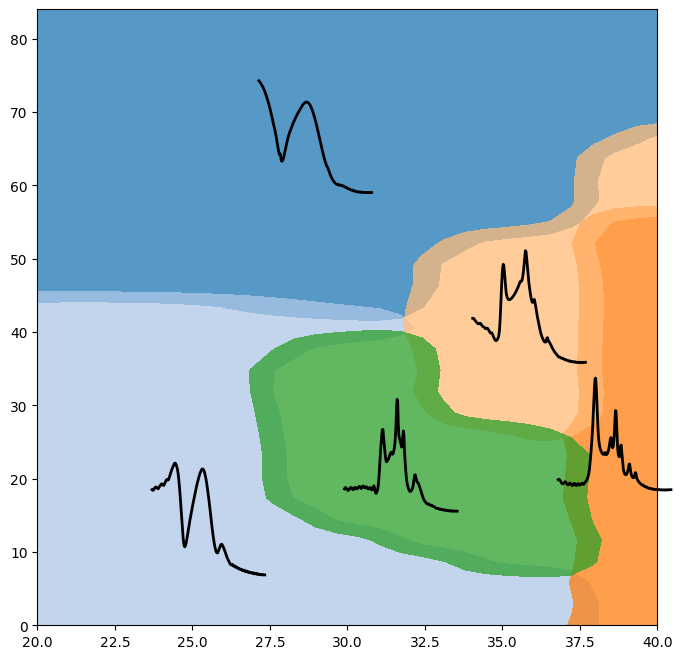

In [11]:
plot_phasemap_contours(data,
                       result,
                       min_prob=0.3, # defines minimum probability of any phase
                       n_grid_points=30 # defines number of grid points to evaluate probabilities
                       )

## Plot data associated with each phase region identified

The following can be used to plot learned template (in corresponding color from above) and the assigned measured SAXS data in gray color to obtain some understanding of nature of assignment and within phase variation

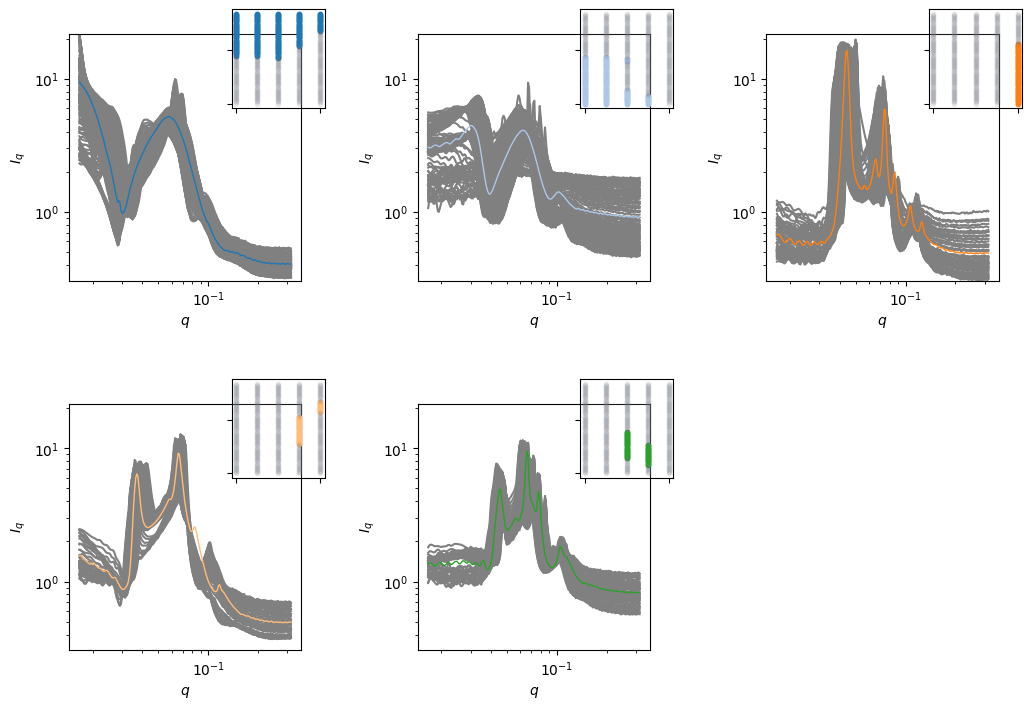

In [12]:
nrows, ncols = 2, 3 # change these values accordinto how many panels you need
fig, axs = plt.subplots(nrows, ncols, figsize = (4*ncols, 4*nrows))
axs = axs.flatten()
[ax.remove() for ax in axs[N_CLUSTERS:]]
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plot_clusters(axs, data, result, mode="input")
plt.show()